## Taller 7

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Set the environment flag for determinism
tf.config.experimental.enable_op_determinism()

In [4]:
df = pd.read_csv('heart.csv')

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


Descripción de las variables:

https://archive.ics.uci.edu/dataset/45/heart+disease


Exploremos el tamaño del df

In [6]:
df.shape

(303, 14)

Identificamos NAs en los datos

In [7]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Definimos listas para las variables categóricas enteras, categóricas string y numéricas.

In [8]:
## Reducimos el numero de variables categoricas a 4
cat_int_feats = ['sex', 'cp', 'fbs', 'exang']

In [9]:
cat_str_feats = ['thal']

In [10]:
# Reducimos el numero de variables numericas a 4
num_feats = ['age', 'chol', 'oldpeak', 'slope']

Agregamos las listas de categorías

In [11]:
feats_ordered = cat_int_feats+cat_str_feats+num_feats

Reordenamos el dataframe de acuerdo con el tipo de variable

In [12]:
df = df[feats_ordered+['target']]

In [13]:
df.head()

,sex,cp,fbs,exang,thal,age,chol,oldpeak,slope,target
0,1,1,1,0,fixed,63,233,2.3,3,0
1,1,4,0,1,normal,67,286,1.5,2,1
2,1,4,0,1,reversible,67,229,2.6,2,0
3,1,3,0,0,normal,37,250,3.5,3,0
4,0,2,0,0,normal,41,204,1.4,1,0


In [14]:
df.columns

Index(['sex', 'cp', 'fbs', 'exang', 'thal', 'age', 'chol', 'oldpeak', 'slope',
       'target'],
      dtype='object')

In [15]:
df["target"].unique()

array([0, 1], dtype=int64)

In [16]:
df.dtypes

sex          int64
cp           int64
fbs          int64
exang        int64
thal        object
age          int64
chol         int64
oldpeak    float64
slope        int64
target       int64
dtype: object

Separamos los datos en entrenamiento, validación y prueba

In [17]:
train = df.sample(frac=0.8, random_state=100)
train.head()

,sex,cp,fbs,exang,thal,age,chol,oldpeak,slope,target
69,0,4,0,0,normal,35,183,1.4,1,0
300,1,4,0,0,reversible,65,254,2.8,2,1
220,1,1,0,0,normal,59,204,0.8,1,0
134,1,3,1,0,reversible,42,240,0.8,3,0
7,0,4,0,1,normal,57,354,0.6,1,0


In [18]:
train.shape

(242, 10)

In [19]:
test = df.drop(train.index)
test.head()

,sex,cp,fbs,exang,thal,age,chol,oldpeak,slope,target
0,1,1,1,0,fixed,63,233,2.3,3,0
2,1,4,0,1,reversible,67,229,2.6,2,0
4,0,2,0,0,normal,41,204,1.4,1,0
8,1,4,0,0,reversible,63,254,1.4,2,1
13,1,2,0,0,reversible,44,263,0.0,1,0


In [20]:
val = train.sample(frac=0.2, random_state=100)

In [21]:
val.shape

(48, 10)

In [22]:
train = train.drop(val.index)

In [23]:
print(train.shape)
print(val.shape)
print(test.shape)

(194, 10)
(48, 10)
(61, 10)


Calculamos estadísticas de cada variable numérica

In [24]:
train.describe()

,sex,cp,fbs,exang,age,chol,oldpeak,slope,target
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,0.664948,3.097938,0.134021,0.319588,54.953608,249.974227,0.990722,1.577320,0.257732
std,0.473230,1.030969,0.341556,0.467523,8.754150,52.803226,1.110625,0.590689,0.438517
min,0.000000,0.000000,0.000000,0.000000,34.000000,126.000000,0.000000,1.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,49.000000,215.750000,0.000000,1.000000,0.000000
50%,1.000000,3.000000,0.000000,0.000000,56.000000,243.000000,0.600000,2.000000,0.000000
75%,1.000000,4.000000,0.000000,1.000000,61.000000,281.000000,1.600000,2.000000,1.000000
max,1.000000,4.000000,1.000000,1.000000,77.000000,564.000000,4.400000,3.000000,1.000000


Función para convertir de dataframe (pandas) a dataset (tensorflow), separando características y etiquetas

In [25]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [26]:
train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)
test_ds = dataframe_to_dataset(test)

In [27]:
type(train_ds)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

Ejemplo de cómo queda el tf.dataset

In [28]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'reversible'>, 'age': <tf.Tensor: shape=(), dtype=int64, numpy=65>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=254>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.8>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=2>}
Target: tf.Tensor(1, shape=(), dtype=int64)


Separamos los datos de entrenamiento, validación y prueba en lotes

In [29]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Función para codificar variables numéricas (Keras docs)

In [30]:
def encode_numerical_feature(feature, name, dataset):
    # Crea capa de normalización para este feature
    normalizer = keras.layers.Normalization()

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende las estadísticas de los datos (media, varianza)
    normalizer.adapt(feature_ds)

    # Aplica la normalización a la variable
    encoded_feature = normalizer(feature)
    return encoded_feature

Función para codificar variables categóricas (Keras docs)

In [31]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    # Crea una capa Lookup para retornas variables 0/1 (dummies)
    # lookup: busca el valor correspondiente de la variable categórica
    lookup = lookup_class(output_mode="binary")

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende el conjunto de posibles valores que toma la variable categórica y asigna enteros
    lookup.adapt(feature_ds)

    # Aplica la conversión de categorías a enteros
    encoded_feature = lookup(feature)
    return encoded_feature

Creamos una lista de inputs para el modelo, de acuerdo con cada tipo de variable

In [32]:
inputs = []
for i in cat_int_feats:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="int64"))

In [33]:
for i in cat_str_feats:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="string"))

In [34]:
for i in num_feats:
  inputs.append(keras.Input(shape=(1,), name=i))

In [35]:
for i in inputs:
   print(i)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='sex'), name='sex', description="created by layer 'sex'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='cp'), name='cp', description="created by layer 'cp'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='fbs'), name='fbs', description="created by layer 'fbs'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='exang'), name='exang', description="created by layer 'exang'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='thal'), name='thal', description="created by layer 'thal'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='age'), name='age', description="created by layer 'age'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='chol'), name='chol', description="created by layer 'chol'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='oldpeak')

Creamos una lista de variables codificadas/normalizadas de acuerdo con su tipo, empleando las funciones de codificación/normalización

In [36]:
feats_encoded=[]

In [37]:
for i,feat in enumerate(cat_int_feats):
  feats_encoded.append(
      encode_categorical_feature(inputs[i], feat, train_ds, False)
  )

In [38]:
len_feats = len(feats_encoded)
len_feats

4

In [39]:
for i,feat in enumerate(cat_str_feats):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, True)
  )

In [40]:
len_feats = len(feats_encoded)
len_feats

5

In [41]:
for i,feat in enumerate(num_feats):
  feats_encoded.append(
      encode_numerical_feature(inputs[len_feats+i], feat, train_ds)
  )

In [42]:
for i in feats_encoded:
  print(i)

KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='integer_lookup/bincount/DenseBincount:0', description="created by layer 'integer_lookup'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='integer_lookup_1/bincount/DenseBincount:0', description="created by layer 'integer_lookup_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='integer_lookup_2/bincount/DenseBincount:0', description="created by layer 'integer_lookup_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='integer_lookup_3/bincount/DenseBincount:0', description="created by layer 'integer_lookup_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='string_lookup/bincount/DenseBincount:0', description="created by layer 'string_lookup'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization/trued

Creamos una capa concatenando todas las variables codificadas

In [43]:
all_feats = keras.layers.concatenate(feats_encoded)

In [44]:
type(all_feats)

keras.src.engine.keras_tensor.KerasTensor

Agregamos una capa densa con 32 neuronas y función de activación relu

In [45]:
model_layers = keras.layers.Dense(32, activation='relu')(all_feats)

Agregamos la capa de salida con 1 neurona (probabilidad de sufrir la enfermedad cardiada) y función de activación sigmoide

In [46]:
model_layers = keras.layers.Dense(1, activation='sigmoid')(model_layers)

Creamos el modelo con las capas ya creadas y las variables de entrada

In [47]:
model = keras.Model(inputs, model_layers)

Compilamos el modelo, definiendo optimizador, función de pérdida y métricas adicionales a capturar

In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])


In [49]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Aseguramos que Keras use TensorFlow como backend, para asegurar que el modelo pueda usar strings como entradas

In [50]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                              

Entrenamos el modelo con los datos en el formato tf.Dataset

In [52]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50

7/7 [==============================] - 6s 378ms/step - loss: 0.7295 - accuracy: 0.4021 - precision: 0.1163 - recall: 0.2000 - roc_auc: 0.3339 - val_loss: 0.6986 - val_accuracy: 0.5208 - val_precision: 0.2105 - val_recall: 0.3333 - val_roc_auc: 0.3877
Epoch 2/50
7/7 [==============================] - 0s 16ms/step - loss: 0.6778 - accuracy: 0.5670 - precision: 0.1600 - recall: 0.1600 - roc_auc: 0.3935 - val_loss: 0.6494 - val_accuracy: 0.6458 - val_precision: 0.2222 - val_recall: 0.1667 - val_roc_auc: 0.5046
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 0.6362 - accuracy: 0.6804 - precision: 0.2692 - recall: 0.1400 - roc_auc: 0.4842 - val_loss: 0.6091 - val_accuracy: 0.7292 - val_precision: 0.4000 - val_recall: 0.1667 - val_roc_auc: 0.6829
Epoch 4/50
7/7 [==============================] - 0s 20ms/step - loss: 0.6030 - accuracy: 0.7629 - precision: 0.8333 - recall: 0.1000 - roc_auc: 0.5863 - val_loss: 0.5755 - val_accuracy: 0.7292 - val_precision: 0.33

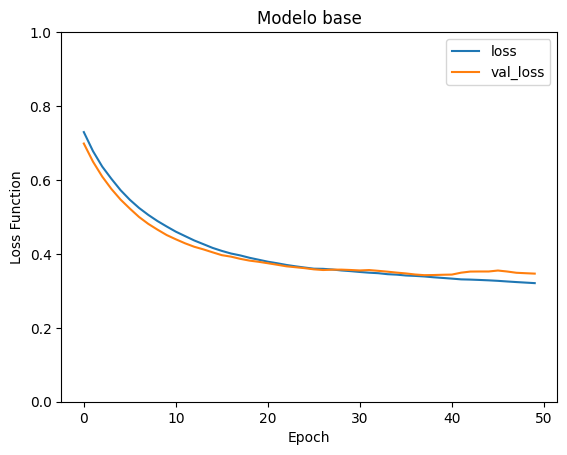

In [53]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
# plt.plot(history.history['accuracy'],label='accuracy')
# plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Modelo base")
plt.legend()

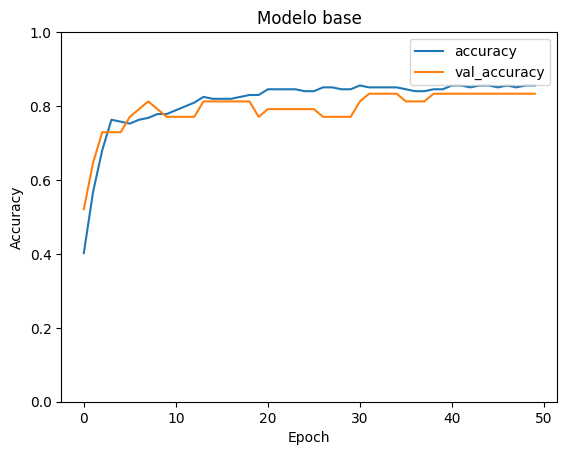

In [54]:
import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Modelo base")
plt.legend()

In [55]:
results = model.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados para modelo base")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

Resultados para modelo base
loss: 0.42728427052497864
accuracy: 0.7704917788505554
precision: 0.7058823704719543
recall: 0.5714285969734192
roc_auc: 0.8898809552192688


## Punto 3 - 1 (optimizador = SGD)

In [56]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

In [57]:
optimizer_exp1 = SGD(learning_rate=0.01, momentum=0.9)

In [58]:
model_exp1 = keras.Model(inputs, model_layers)

Compilamos el modelo, definiendo optimizador, función de pérdida y métricas adicionales a capturar

In [59]:
model_exp1.compile(optimizer=optimizer_exp1, loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])


In [60]:
keras.utils.plot_model(model_exp1, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [61]:
model_exp1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [62]:
history_exp1 = model_exp1.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 6s 304ms/step - loss: 0.3205 - accuracy: 0.8557 - precision_1: 0.7619 - recall_1: 0.6400 - roc_auc: 0.9165 - val_loss: 0.3462 - val_accuracy: 0.8333 - val_precision_1: 0.6429 - val_recall_1: 0.7500 - val_roc_auc: 0.9005
Epoch 2/50
7/7 [==============================] - 0s 19ms/step - loss: 0.3193 - accuracy: 0.8557 - precision_1: 0.7619 - recall_1: 0.6400 - roc_auc: 0.9170 - val_loss: 0.3485 - val_accuracy: 0.8333 - val_precision_1: 0.6429 - val_recall_1: 0.7500 - val_roc_auc: 0.8993
Epoch 3/50
7/7 [==============================] - 0s 19ms/step - loss: 0.3194 - accuracy: 0.8505 - precision_1: 0.7442 - recall_1: 0.6400 - roc_auc: 0.9158 - val_loss: 0.3604 - val_accuracy: 0.8125 - val_precision_1: 0.6000 - val_recall_1: 0.7500 - val_roc_auc: 0.8924
Epoch 4/50
7/7 [==============================] - 0s 22ms/step - loss: 0.3166 - accuracy: 0.8557 - precision_1: 0.7500 - recall_1: 0.6600 - roc_auc: 0.9178 - val_loss: 0.3593 - val_accuracy: 0

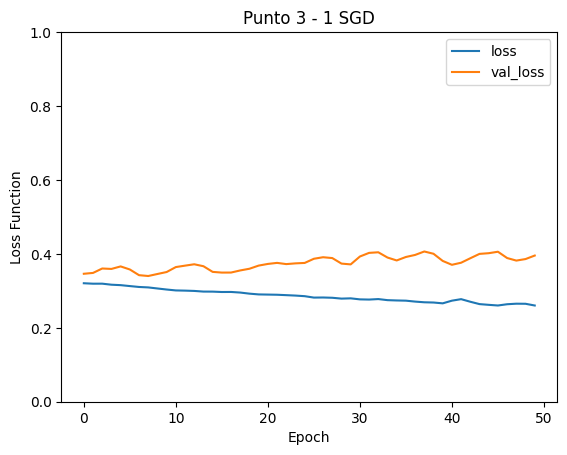

In [63]:
import matplotlib.pyplot as plt
plt.plot(history_exp1.history['loss'], label='loss')
plt.plot(history_exp1.history['val_loss'], label='val_loss')
# plt.plot(history.history['accuracy'],label='accuracy')
# plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 3 - 1 SGD")
plt.legend()

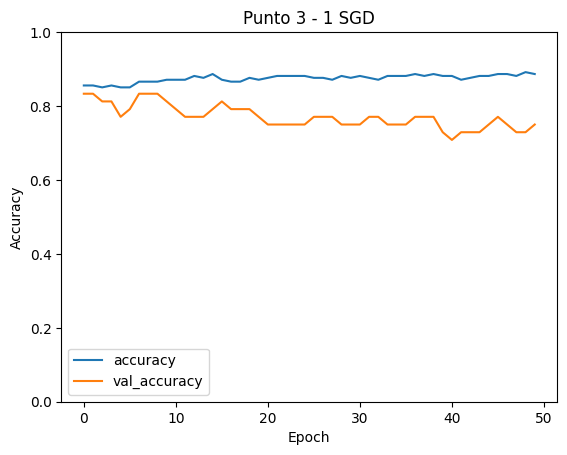

In [64]:
import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history_exp1.history['accuracy'],label='accuracy')
plt.plot(history_exp1.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 3 - 1 SGD")
plt.legend()

In [65]:
results_exp1 = model_exp1.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 3 - 1 SGD")
for name, value in zip(model_exp1.metrics_names, results_exp1):
    print(f"{name}: {value}")

Resultados Punto 3 - 1 SGD
loss: 0.4590449929237366
accuracy: 0.7540983557701111
precision_1: 0.6666666865348816
recall_1: 0.5714285969734192
roc_auc: 0.8833333253860474


## Punto 3 - 2 (RMS)

In [66]:
optimizer_exp2 = RMSprop(learning_rate=0.001)

In [67]:
model_exp2 = keras.Model(inputs, model_layers)

Compilamos el modelo, definiendo optimizador, función de pérdida y métricas adicionales a capturar

In [68]:
model_exp2.compile(optimizer=optimizer_exp2, loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])


In [69]:
model_exp2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [70]:
history_exp2 = model_exp2.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 4s 197ms/step - loss: 0.2609 - accuracy: 0.8866 - precision_2: 0.8182 - recall_2: 0.7200 - roc_auc: 0.9488 - val_loss: 0.4018 - val_accuracy: 0.7292 - val_precision_2: 0.4706 - val_recall_2: 0.6667 - val_roc_auc: 0.8681
Epoch 2/50
7/7 [==============================] - 0s 18ms/step - loss: 0.2569 - accuracy: 0.8918 - precision_2: 0.8222 - recall_2: 0.7400 - roc_auc: 0.9500 - val_loss: 0.3990 - val_accuracy: 0.7292 - val_precision_2: 0.4706 - val_recall_2: 0.6667 - val_roc_auc: 0.8681
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 0.2558 - accuracy: 0.8814 - precision_2: 0.8140 - recall_2: 0.7000 - roc_auc: 0.9513 - val_loss: 0.4103 - val_accuracy: 0.7292 - val_precision_2: 0.4706 - val_recall_2: 0.6667 - val_roc_auc: 0.8681
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.2544 - accuracy: 0.8918 - precision_2: 0.8222 - recall_2: 0.7400 - roc_auc: 0.9505 - val_loss: 0.4092 - val_accuracy: 0

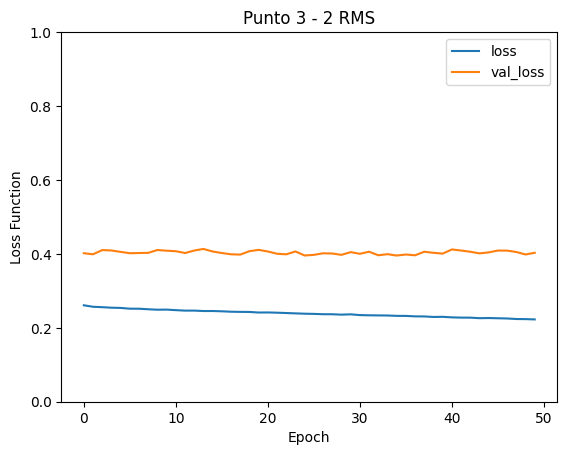

In [71]:
import matplotlib.pyplot as plt
plt.plot(history_exp2.history['loss'], label='loss')
plt.plot(history_exp2.history['val_loss'], label='val_loss')
# plt.plot(history.history['accuracy'],label='accuracy')
# plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 3 - 2 RMS")
plt.legend()

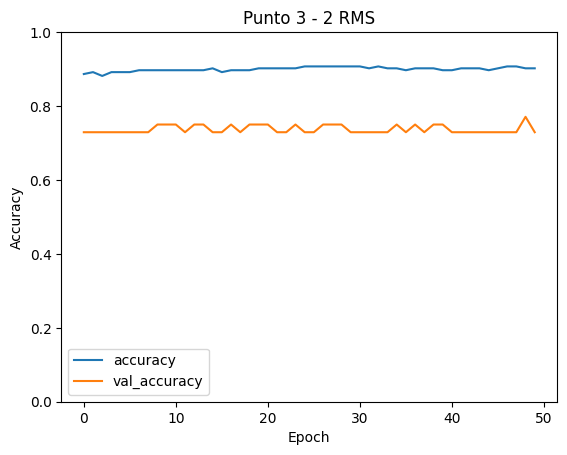

In [72]:
import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history_exp2.history['accuracy'],label='accuracy')
plt.plot(history_exp2.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 3 - 2 RMS")
plt.legend()

In [73]:
results_exp2 = model_exp2.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 3 - 2 RMS")
for name, value in zip(model_exp2.metrics_names, results_exp1):
    print(f"{name}: {value}")

Resultados Punto 3 - 2 RMS
loss: 0.4590449929237366
accuracy: 0.7540983557701111
precision_2: 0.6666666865348816
recall_2: 0.5714285969734192
roc_auc: 0.8833333253860474


## Punto 4 - 1 (tasa = 0.01)

In [74]:
model_4_1 = keras.Model(inputs, model_layers)

In [75]:
learning_rate_1 = 0.01
optimizer = Adam(learning_rate=learning_rate_1)
model_4_1.compile(optimizer=optimizer, loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [76]:
model_4_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [77]:
history_4_1 = model_4_1.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 6s 399ms/step - loss: 0.2410 - accuracy: 0.9278 - precision_3: 0.8333 - recall_3: 0.9000 - roc_auc: 0.9551 - val_loss: 0.3779 - val_accuracy: 0.7292 - val_precision_3: 0.4615 - val_recall_3: 0.5000 - val_roc_auc: 0.8704
Epoch 2/50
7/7 [==============================] - 0s 18ms/step - loss: 0.2519 - accuracy: 0.8814 - precision_3: 0.8857 - recall_3: 0.6200 - roc_auc: 0.9624 - val_loss: 0.3810 - val_accuracy: 0.7292 - val_precision_3: 0.4615 - val_recall_3: 0.5000 - val_roc_auc: 0.8646
Epoch 3/50
7/7 [==============================] - 0s 20ms/step - loss: 0.2383 - accuracy: 0.8814 - precision_3: 0.7872 - recall_3: 0.7400 - roc_auc: 0.9540 - val_loss: 0.4447 - val_accuracy: 0.7292 - val_precision_3: 0.4737 - val_recall_3: 0.7500 - val_roc_auc: 0.8588
Epoch 4/50
7/7 [==============================] - 0s 55ms/step - loss: 0.2242 - accuracy: 0.9124 - precision_3: 0.8235 - recall_3: 0.8400 - roc_auc: 0.9636 - val_loss: 0.3961 - val_accuracy: 0

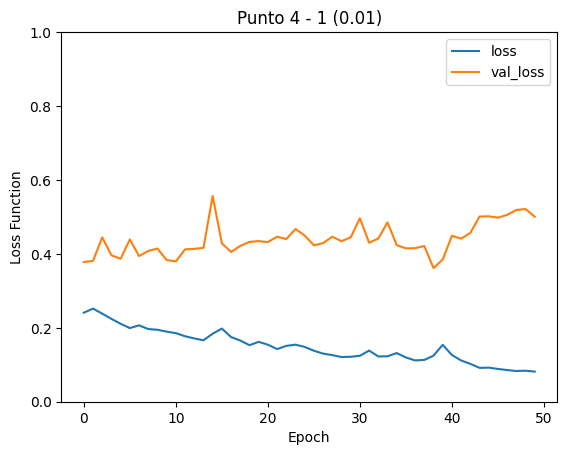

In [78]:
import matplotlib.pyplot as plt
plt.plot(history_4_1.history['loss'], label='loss')
plt.plot(history_4_1.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 4 - 1 (0.01)")
plt.legend()

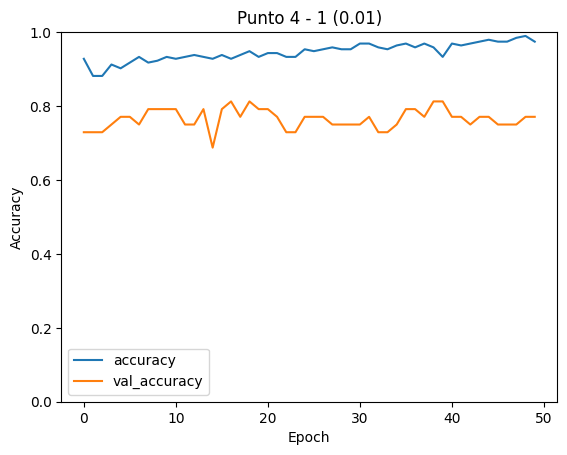

In [79]:
import matplotlib.pyplot as plt
plt.plot(history_4_1.history['accuracy'],label='accuracy')
plt.plot(history_4_1.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 4 - 1 (0.01)")
plt.legend()

In [80]:
results_4_1 = model_4_1.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 4 - 1 (0.01)")
for name, value in zip(model_4_1.metrics_names, results_4_1):
    print(f"{name}: {value}")

Resultados Punto 4 - 1 (0.01)
loss: 0.7354776263237
accuracy: 0.7704917788505554
precision_3: 0.7058823704719543
recall_3: 0.5714285969734192
roc_auc: 0.8630951642990112


## Punto 4 - 2 (tasa = 0.0001)

In [81]:
model_4_2 = keras.Model(inputs, model_layers)

In [82]:
learning_rate_2 = 0.0001
optimizer = Adam(learning_rate=learning_rate_2)
model_4_2.compile(optimizer=optimizer, loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [83]:
model_4_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [84]:
history_4_2 = model_4_2.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 6s 255ms/step - loss: 0.0776 - accuracy: 0.9742 - precision_4: 0.9592 - recall_4: 0.9400 - roc_auc: 0.9983 - val_loss: 0.5007 - val_accuracy: 0.7708 - val_precision_4: 0.5385 - val_recall_4: 0.5833 - val_roc_auc: 0.8530
Epoch 2/50
7/7 [==============================] - 0s 29ms/step - loss: 0.0772 - accuracy: 0.9742 - precision_4: 0.9592 - recall_4: 0.9400 - roc_auc: 0.9983 - val_loss: 0.5022 - val_accuracy: 0.7500 - val_precision_4: 0.5000 - val_recall_4: 0.5833 - val_roc_auc: 0.8530
Epoch 3/50
7/7 [==============================] - 0s 37ms/step - loss: 0.0770 - accuracy: 0.9742 - precision_4: 0.9592 - recall_4: 0.9400 - roc_auc: 0.9983 - val_loss: 0.5037 - val_accuracy: 0.7500 - val_precision_4: 0.5000 - val_recall_4: 0.5833 - val_roc_auc: 0.8519
Epoch 4/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0767 - accuracy: 0.9742 - precision_4: 0.9592 - recall_4: 0.9400 - roc_auc: 0.9983 - val_loss: 0.5043 - val_accuracy: 0

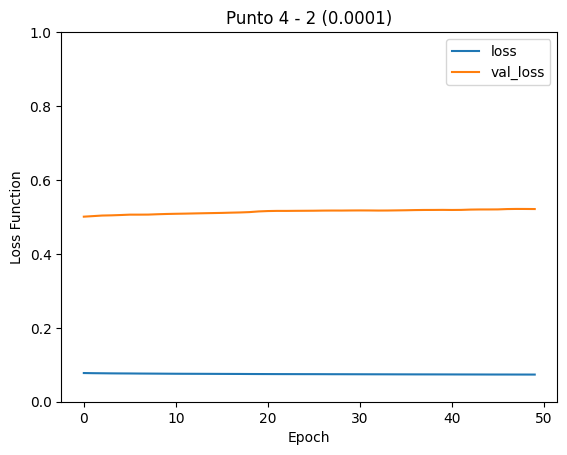

In [85]:
import matplotlib.pyplot as plt
plt.plot(history_4_2.history['loss'], label='loss')
plt.plot(history_4_2.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 4 - 2 (0.0001)")
plt.legend()

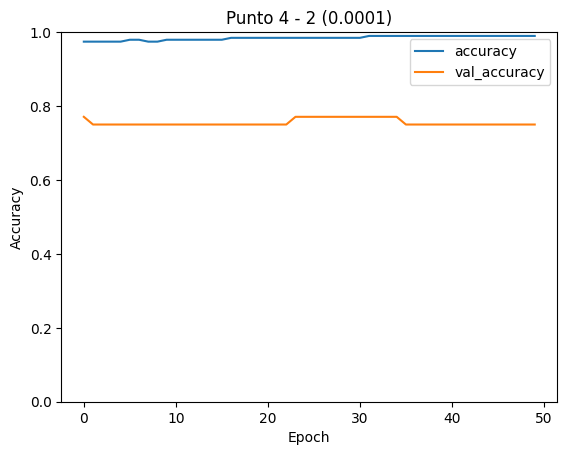

In [86]:
import matplotlib.pyplot as plt
plt.plot(history_4_2.history['accuracy'],label='accuracy')
plt.plot(history_4_2.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 4 - 2 (0.0001)")
plt.legend()

In [87]:
results_4_2 = model_4_2.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 4 - 2 (0.0001)")
for name, value in zip(model_4_2.metrics_names, results_4_2):
    print(f"{name}: {value}")

Resultados Punto 4 - 2 (0.0001)
loss: 0.7381018400192261
accuracy: 0.8032786846160889
precision_4: 0.7368420958518982
recall_4: 0.6666666865348816
roc_auc: 0.8607141971588135


## Punto 4 - 3 (tasa = 0.005)

In [88]:
model_4_3 = keras.Model(inputs, model_layers)

In [89]:
learning_rate_3 = 0.005
optimizer = Adam(learning_rate=learning_rate_3)
model_4_3.compile(optimizer=optimizer, loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [90]:
model_4_3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [91]:
history_4_3 = model_4_3.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 5s 290ms/step - loss: 0.0838 - accuracy: 0.9794 - precision_5: 0.9423 - recall_5: 0.9800 - roc_auc: 0.9983 - val_loss: 0.5393 - val_accuracy: 0.7708 - val_precision_5: 0.5294 - val_recall_5: 0.7500 - val_roc_auc: 0.8472
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0743 - accuracy: 0.9845 - precision_5: 0.9434 - recall_5: 1.0000 - roc_auc: 0.9986 - val_loss: 0.5347 - val_accuracy: 0.7708 - val_precision_5: 0.5294 - val_recall_5: 0.7500 - val_roc_auc: 0.8519
Epoch 3/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0724 - accuracy: 0.9794 - precision_5: 0.9600 - recall_5: 0.9600 - roc_auc: 0.9985 - val_loss: 0.5307 - val_accuracy: 0.7500 - val_precision_5: 0.5000 - val_recall_5: 0.5833 - val_roc_auc: 0.8484
Epoch 4/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0719 - accuracy: 0.9845 - precision_5: 0.9608 - recall_5: 0.9800 - roc_auc: 0.9992 - val_loss: 0.5539 - val_accuracy: 0

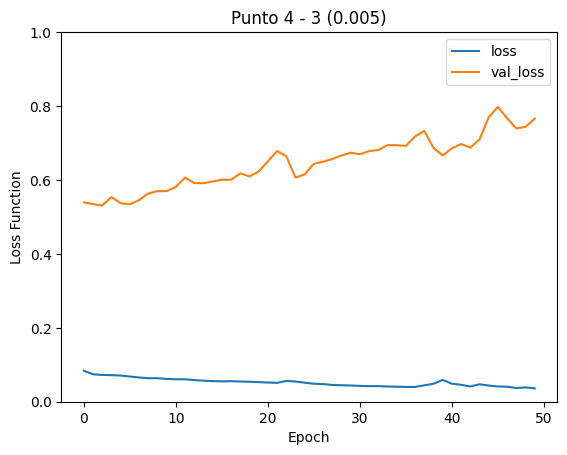

In [92]:
import matplotlib.pyplot as plt
plt.plot(history_4_3.history['loss'], label='loss')
plt.plot(history_4_3.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 4 - 3 (0.005)")
plt.legend()

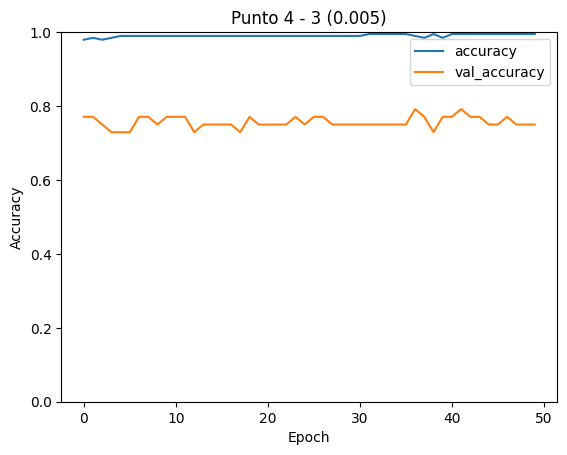

In [93]:
import matplotlib.pyplot as plt
plt.plot(history_4_3.history['accuracy'],label='accuracy')
plt.plot(history_4_3.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 4 - 3 (0.005)")
plt.legend()

In [94]:
results_4_3 = model_4_3.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 4 - 3 (0.005)")
for name, value in zip(model_4_3.metrics_names, results_4_3):
    print(f"{name}: {value}")

Resultados Punto 4 - 3 (0.005)
loss: 1.0269986391067505
accuracy: 0.7540983557701111
precision_5: 0.6875
recall_5: 0.523809552192688
roc_auc: 0.8392857313156128


## Punto 6 - 1 (3 capas)

In [95]:
model_layers_3 = keras.layers.Dense(64, activation='relu')(all_feats)
model_layers_3 = keras.layers.Dense(32, activation='relu')(model_layers_3)
model_layers_3 = keras.layers.Dense(1, activation='sigmoid')(model_layers_3)

model_3_layers = keras.Model(inputs, model_layers_3)
model_3_layers.compile(optimizer='adam', 
                       loss='binary_crossentropy', 
                       metrics=["accuracy", 
                                tf.keras.metrics.Precision(), 
                                tf.keras.metrics.Recall(), 
                                tf.keras.metrics.AUC(name='roc_auc')])

In [96]:
model_3_layers.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [97]:
history_6_1 = model_3_layers.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 8s 341ms/step - loss: 0.7041 - accuracy: 0.4948 - precision_6: 0.2818 - recall_6: 0.6200 - roc_auc: 0.5163 - val_loss: 0.6611 - val_accuracy: 0.6667 - val_precision_6: 0.3333 - val_recall_6: 0.3333 - val_roc_auc: 0.5775
Epoch 2/50
7/7 [==============================] - 0s 30ms/step - loss: 0.6330 - accuracy: 0.7268 - precision_6: 0.4348 - recall_6: 0.2000 - roc_auc: 0.6656 - val_loss: 0.6037 - val_accuracy: 0.7708 - val_precision_6: 1.0000 - val_recall_6: 0.0833 - val_roc_auc: 0.6424
Epoch 3/50
7/7 [==============================] - 0s 30ms/step - loss: 0.5809 - accuracy: 0.7423 - precision_6: 0.5000 - recall_6: 0.0200 - roc_auc: 0.7401 - val_loss: 0.5576 - val_accuracy: 0.7708 - val_precision_6: 1.0000 - val_recall_6: 0.0833 - val_roc_auc: 0.7419
Epoch 4/50
7/7 [==============================] - 0s 20ms/step - loss: 0.5387 - accuracy: 0.7474 - precision_6: 1.0000 - recall_6: 0.0200 - roc_auc: 0.8256 - val_loss: 0.5204 - val_accuracy: 0

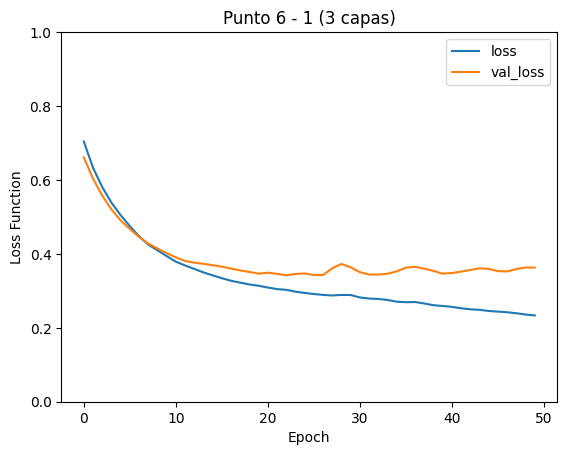

In [98]:
import matplotlib.pyplot as plt
plt.plot(history_6_1.history['loss'], label='loss')
plt.plot(history_6_1.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 6 - 1 (3 capas)")
plt.legend()

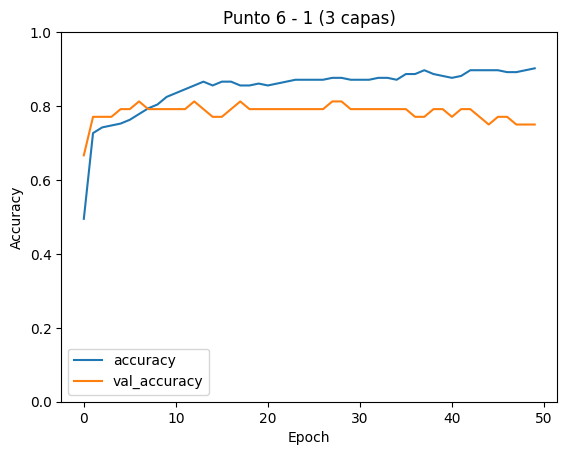

In [99]:
import matplotlib.pyplot as plt
plt.plot(history_6_1.history['accuracy'],label='accuracy')
plt.plot(history_6_1.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 6 - 1 (3 capas)")
plt.legend()

In [100]:
results_6_1 = model_3_layers.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 6 - 1 (3 capas)")
for name, value in zip(model_3_layers.metrics_names, results_6_1):
    print(f"{name}: {value}")

Resultados Punto 6 - 1 (3 capas)
loss: 0.4491272568702698
accuracy: 0.7540983557701111
precision_6: 0.6666666865348816
recall_6: 0.5714285969734192
roc_auc: 0.886904776096344


## Punto 6 - 2 (6 capas)

In [101]:
model_layers_6 = keras.layers.Dense(128, activation='relu')(all_feats)
model_layers_6 = keras.layers.Dense(64, activation='relu')(model_layers_6)
model_layers_6 = keras.layers.Dense(64, activation='relu')(model_layers_6)
model_layers_6 = keras.layers.Dense(32, activation='relu')(model_layers_6)
model_layers_6 = keras.layers.Dense(32, activation='relu')(model_layers_6)
model_layers_6 = keras.layers.Dense(1, activation='sigmoid')(model_layers_6)

In [102]:
model_6_layers = keras.Model(inputs, model_layers_6)
model_6_layers.compile(optimizer='adam', 
                       loss='binary_crossentropy', 
                       metrics=["accuracy", 
                                tf.keras.metrics.Precision(), 
                                tf.keras.metrics.Recall(), 
                                tf.keras.metrics.AUC(name='roc_auc')])

In [103]:
model_6_layers.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [104]:
history_6_2 = model_6_layers.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 8s 301ms/step - loss: 0.6480 - accuracy: 0.7268 - precision_7: 0.2857 - recall_7: 0.0400 - roc_auc: 0.5955 - val_loss: 0.5741 - val_accuracy: 0.7500 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_roc_auc: 0.8843
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 0.5472 - accuracy: 0.7423 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - roc_auc: 0.8397 - val_loss: 0.4777 - val_accuracy: 0.7500 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_roc_auc: 0.8889
Epoch 3/50
7/7 [==============================] - 0s 47ms/step - loss: 0.4735 - accuracy: 0.7423 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - roc_auc: 0.8569 - val_loss: 0.4024 - val_accuracy: 0.7917 - val_precision_7: 1.0000 - val_recall_7: 0.1667 - val_roc_auc: 0.9039
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.4125 - accuracy: 0.7629 - precision_7: 0.7000 - recall_7: 0.1400 - roc_auc: 0.8817 - va

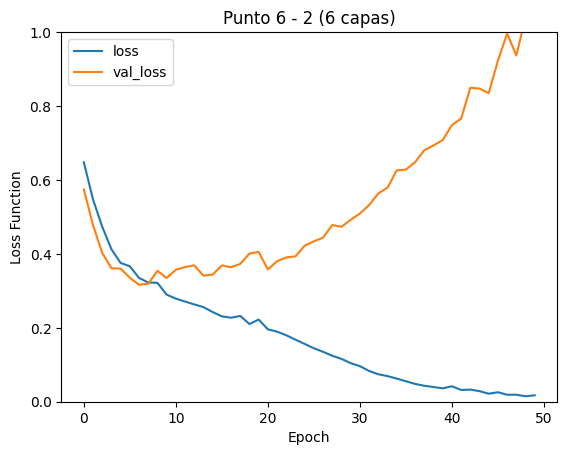

In [105]:
import matplotlib.pyplot as plt
plt.plot(history_6_2.history['loss'], label='loss')
plt.plot(history_6_2.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 6 - 2 (6 capas)")
plt.legend()

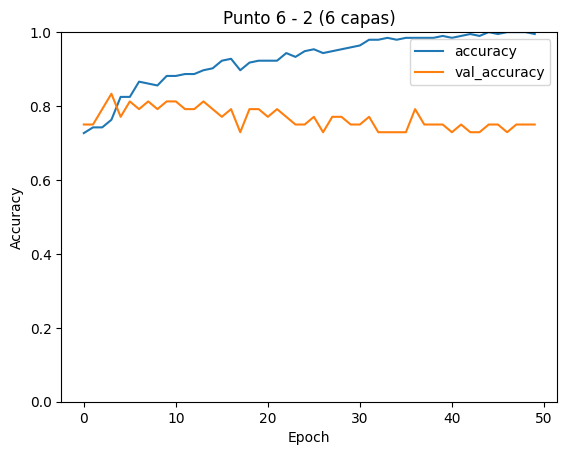

In [106]:
import matplotlib.pyplot as plt
plt.plot(history_6_2.history['accuracy'],label='accuracy')
plt.plot(history_6_2.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 6 - 2 (6 capas)")
plt.legend()

In [107]:
results_6_2 = model_6_layers.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 6 - 2 (6 capas)")
for name, value in zip(model_6_layers.metrics_names, results_6_2):
    print(f"{name}: {value}")

Resultados Punto 6 - 2 (6 capas)
loss: 1.2952580451965332
accuracy: 0.8196721076965332
precision_7: 0.8125
recall_7: 0.6190476417541504
roc_auc: 0.8184523582458496


## Punto 6 - 3 (18 capas)

In [108]:
model_layers_18 = keras.layers.Dense(256, activation='relu')(all_feats)
for _ in range(16):
    model_layers_18 = keras.layers.Dense(128, activation='relu')(model_layers_18)
model_layers_18 = keras.layers.Dense(1, activation='sigmoid')(model_layers_18)

model_18_layers = keras.Model(inputs, model_layers_18)
model_18_layers.compile(optimizer='adam', 
                        loss='binary_crossentropy', 
                        metrics=["accuracy", 
                                 tf.keras.metrics.Precision(), 
                                 tf.keras.metrics.Recall(), 
                                 tf.keras.metrics.AUC(name='roc_auc')])


In [109]:
model_18_layers.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [110]:
history_6_3 = model_18_layers.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 14s 455ms/step - loss: 0.6666 - accuracy: 0.7371 - precision_8: 0.4000 - recall_8: 0.0400 - roc_auc: 0.5272 - val_loss: 0.5641 - val_accuracy: 0.7500 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_roc_auc: 0.7963
Epoch 2/50
7/7 [==============================] - 0s 26ms/step - loss: 0.5556 - accuracy: 0.7423 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - roc_auc: 0.6282 - val_loss: 0.4619 - val_accuracy: 0.7500 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_roc_auc: 0.8623
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 0.5070 - accuracy: 0.7423 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - roc_auc: 0.8336 - val_loss: 0.4640 - val_accuracy: 0.7500 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_roc_auc: 0.8507
Epoch 4/50
7/7 [==============================] - 0s 23ms/step - loss: 0.4457 - accuracy: 0.7423 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - roc

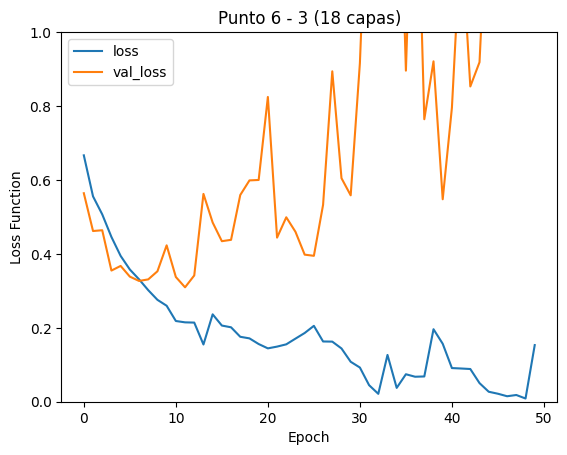

In [111]:
import matplotlib.pyplot as plt
plt.plot(history_6_3.history['loss'], label='loss')
plt.plot(history_6_3.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 6 - 3 (18 capas)")
plt.legend()

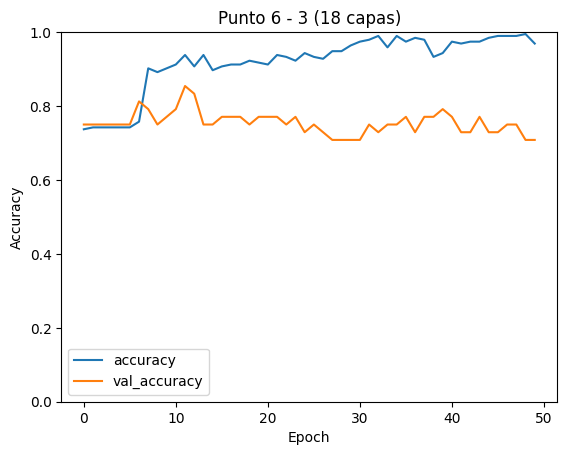

In [112]:
import matplotlib.pyplot as plt
plt.plot(history_6_3.history['accuracy'],label='accuracy')
plt.plot(history_6_3.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 6 - 3 (18 capas)")
plt.legend()

In [113]:
results_6_3 = model_18_layers.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 6 - 3 (18 capas)")
for name, value in zip(model_18_layers.metrics_names, results_6_3):
    print(f"{name}: {value}")

Resultados Punto 6 - 3 (18 capas)
loss: 1.8313462734222412
accuracy: 0.7049180269241333
precision_8: 0.800000011920929
recall_8: 0.190476194024086
roc_auc: 0.7851190567016602


## Punto 7 - 1 (Tanh-sigmoid)

In [114]:
model_layers1 = keras.layers.Dense(32, activation='tanh')(all_feats)
model_layers1 = keras.layers.Dense(1, activation='sigmoid')(model_layers1)

In [115]:
model_7_1 = keras.Model(inputs, model_layers1)

In [116]:
model_7_1.compile(optimizer='adam', loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [117]:
model_7_1.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [118]:
history_7_1 = model_7_1.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 6s 273ms/step - loss: 0.6664 - accuracy: 0.6649 - precision_9: 0.1429 - recall_9: 0.0600 - roc_auc: 0.3560 - val_loss: 0.6627 - val_accuracy: 0.7500 - val_precision_9: 0.5000 - val_recall_9: 0.0833 - val_roc_auc: 0.2894
Epoch 2/50
7/7 [==============================] - 0s 45ms/step - loss: 0.6161 - accuracy: 0.7320 - precision_9: 0.4000 - recall_9: 0.0800 - roc_auc: 0.4532 - val_loss: 0.6171 - val_accuracy: 0.7500 - val_precision_9: 0.5000 - val_recall_9: 0.0833 - val_roc_auc: 0.3762
Epoch 3/50
7/7 [==============================] - 0s 42ms/step - loss: 0.5766 - accuracy: 0.7423 - precision_9: 0.5000 - recall_9: 0.1000 - roc_auc: 0.5569 - val_loss: 0.5779 - val_accuracy: 0.7500 - val_precision_9: 0.5000 - val_recall_9: 0.0833 - val_roc_auc: 0.4884
Epoch 4/50
7/7 [==============================] - 0s 20ms/step - loss: 0.5437 - accuracy: 0.7526 - precision_9: 0.5833 - recall_9: 0.1400 - roc_auc: 0.6449 - val_loss: 0.5442 - val_accuracy: 0

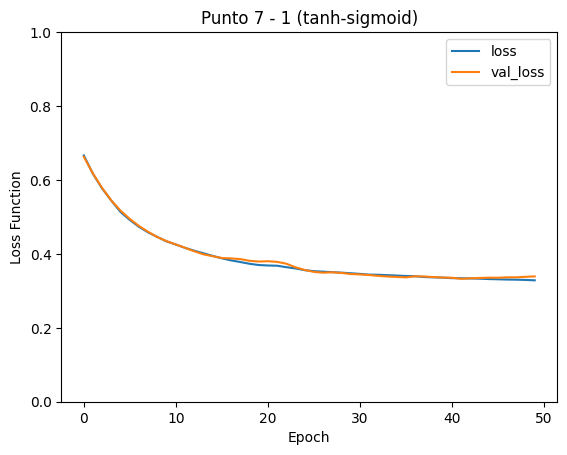

In [119]:
import matplotlib.pyplot as plt
plt.plot(history_7_1.history['loss'], label='loss')
plt.plot(history_7_1.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 7 - 1 (tanh-sigmoid)")
plt.legend()

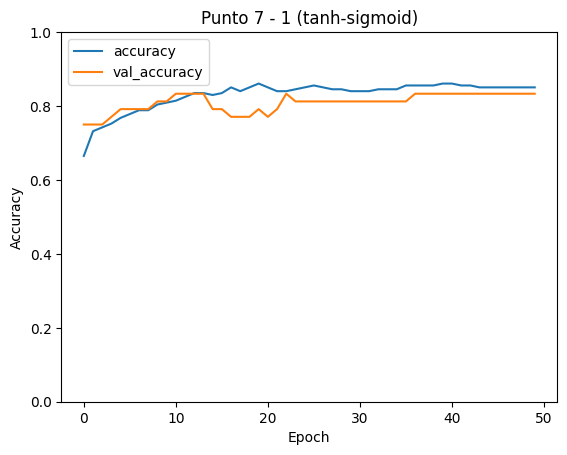

In [120]:
import matplotlib.pyplot as plt
plt.plot(history_7_1.history['accuracy'],label='accuracy')
plt.plot(history_7_1.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 7 - 1 (tanh-sigmoid)")
plt.legend()

In [121]:
results_7_1 = model_7_1.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 7 - 1 (tanh-sigmoid)")
for name, value in zip(model_7_1.metrics_names, results_7_1):
    print(f"{name}: {value}")

Resultados Punto 7 - 1 (tanh-sigmoid)
loss: 0.41372156143188477
accuracy: 0.7868852615356445
precision_9: 0.7222222089767456
recall_9: 0.6190476417541504
roc_auc: 0.903571367263794


## Punto 7 - 2 (sigmoid-relu)

In [122]:
model_layers2 = keras.layers.Dense(32, activation='sigmoid')(all_feats)
model_layers2 = keras.layers.Dense(1, activation='relu')(model_layers2)

In [123]:
model_7_2 = keras.Model(inputs, model_layers2)

In [124]:
model_7_2.compile(optimizer='adam', loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [125]:
model_7_2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                           

In [126]:
history_7_2 = model_7_2.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 9s 564ms/step - loss: 3.9755 - accuracy: 0.7423 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - roc_auc: 0.5000 - val_loss: 3.8562 - val_accuracy: 0.7500 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 2/50
7/7 [==============================] - 0s 24ms/step - loss: 3.9755 - accuracy: 0.7423 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - roc_auc: 0.5000 - val_loss: 3.8562 - val_accuracy: 0.7500 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 3/50
7/7 [==============================] - 0s 24ms/step - loss: 3.9755 - accuracy: 0.7423 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - roc_auc: 0.5000 - val_loss: 3.8562 - val_accuracy: 0.7500 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 4/50
7/7 [==============================] - 0s 22ms/step - loss: 3.9755 - accuracy: 0.7423 - precision_10: 0.0000e+00 - recall

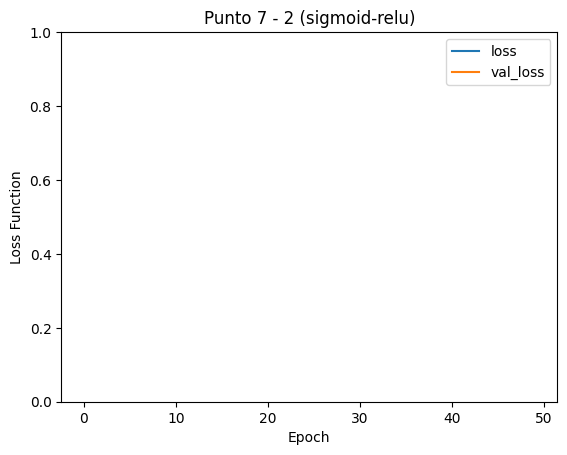

In [127]:
plt.plot(history_7_2.history['loss'], label='loss')
plt.plot(history_7_2.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 7 - 2 (sigmoid-relu)")
plt.legend()

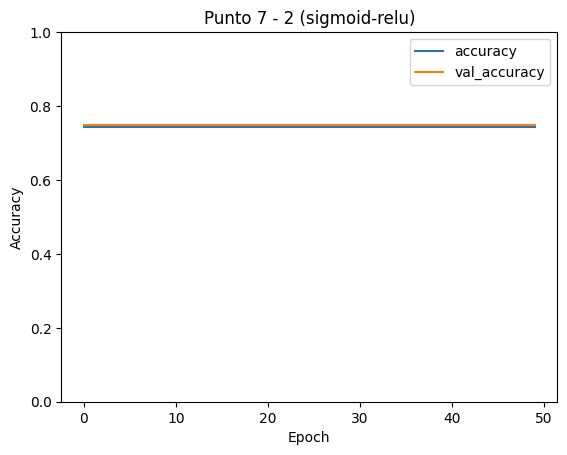

In [128]:
import matplotlib.pyplot as plt
plt.plot(history_7_2.history['accuracy'],label='accuracy')
plt.plot(history_7_2.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 7 - 2 (sigmoid-relu)")
plt.legend()

In [129]:
results_7_2 = model_7_2.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 7 - 2 (sigmoid-relu)")
for name, value in zip(model_7_2.metrics_names, results_7_2):
    print(f"{name}: {value}")

Resultados Punto 7 - 2 (sigmoid-relu)
loss: 5.31022834777832
accuracy: 0.6557376980781555
precision_10: 0.0
recall_10: 0.0
roc_auc: 0.5


## Punto 7 - 3 (relu-tanh)

In [130]:
model_layers3 = keras.layers.Dense(32, activation='relu')(all_feats)
model_layers3 = keras.layers.Dense(1, activation='tanh')(model_layers3)

In [131]:
model_7_3 = keras.Model(inputs, model_layers3)

In [132]:
model_7_3.compile(optimizer='adam', loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [133]:
model_7_3.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                           

In [134]:
history_7_3 = model_7_3.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 5s 298ms/step - loss: 2.1062 - accuracy: 0.7423 - precision_11: 0.5000 - recall_11: 0.0400 - roc_auc: 0.5588 - val_loss: 0.8563 - val_accuracy: 0.7083 - val_precision_11: 0.2500 - val_recall_11: 0.0833 - val_roc_auc: 0.6806
Epoch 2/50
7/7 [==============================] - 0s 23ms/step - loss: 1.5787 - accuracy: 0.7371 - precision_11: 0.4000 - recall_11: 0.0400 - roc_auc: 0.6414 - val_loss: 0.7661 - val_accuracy: 0.6875 - val_precision_11: 0.2857 - val_recall_11: 0.1667 - val_roc_auc: 0.7083
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 1.2505 - accuracy: 0.7423 - precision_11: 0.5000 - recall_11: 0.1600 - roc_auc: 0.6846 - val_loss: 0.4809 - val_accuracy: 0.7083 - val_precision_11: 0.4167 - val_recall_11: 0.4167 - val_roc_auc: 0.7546
Epoch 4/50
7/7 [==============================] - 0s 15ms/step - loss: 0.9176 - accuracy: 0.7320 - precision_11: 0.4643 - recall_11: 0.2600 - roc_auc: 0.7220 - val_loss: 0.4549 - v

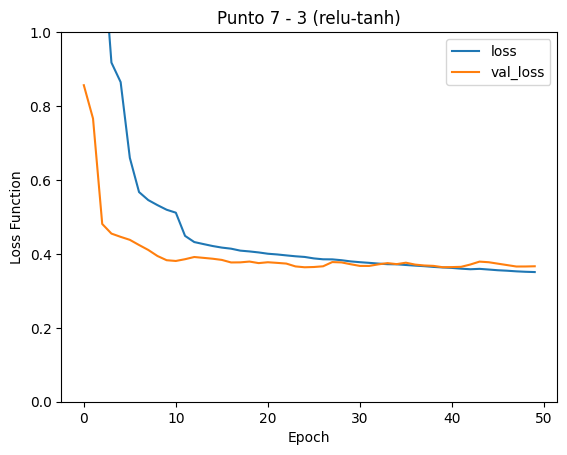

In [135]:
plt.plot(history_7_3.history['loss'], label='loss')
plt.plot(history_7_3.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 7 - 3 (relu-tanh)")
plt.legend()

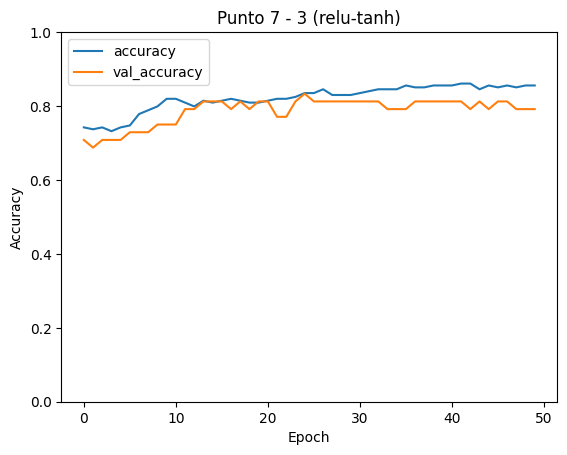

In [136]:
import matplotlib.pyplot as plt
plt.plot(history_7_3.history['accuracy'],label='accuracy')
plt.plot(history_7_3.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 7 - 3 (relu-tanh)")
plt.legend()

In [137]:
results_7_3 = model_7_3.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 7 - 3(relu-tanh)")
for name, value in zip(model_7_3.metrics_names, results_7_3):
    print(f"{name}: {value}")

Resultados Punto 7 - 3(relu-tanh)
loss: 1.0771002769470215
accuracy: 0.7540983557701111
precision_11: 0.6666666865348816
recall_11: 0.5714285969734192
roc_auc: 0.8255952596664429
